In [93]:
import os
import openai
import pandas as pd
import numpy as np
import h5py
import requests
import json
import re
import openpyxl
import matplotlib.pyplot as plt
import concurrent.futures
from multiprocessing import Pool

In [2]:
## Get Key
def read_first_cell(file_path):
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active
    first_cell = sheet.cell(row=1, column=1)
    return first_cell.value

file_path = '../openaikey.xlsx'  
first_cell_value = read_first_cell(file_path)

openai.api_key=first_cell_value
API_ENDPOINT = "https://api.openai.com/v1/chat/completions"

### Using a dataframe to generate fake value

In [101]:
# Load and preprocess data
dir = '~/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'Windy/WindyMASigned.h5')

In [102]:
df1=df[0:150000]
df1=df1.round(3)

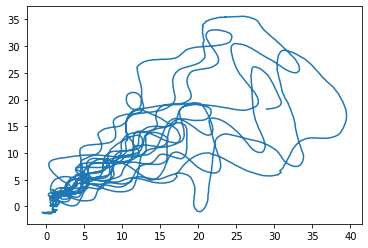

In [103]:
plt.plot(df1.xsrc,df1.ysrc)

### Train Data

In [104]:
# Set the chunk size
chunk_size = 60

# Divide the DataFrame into smaller chunks
num_chunks = (len(df1) - 1) // chunk_size + 1

for chunk_index in range(num_chunks):
    start_index = chunk_index * chunk_size
    end_index = min((chunk_index + 1) * chunk_size, len(df1))
    chunk_df = df1.iloc[start_index:end_index]

    # Convert the chunk DataFrame to textual format
    text_data = ""
    for idx, row in chunk_df.iterrows():
        text_data += f"Odor encounter: {row['odor']}, Location: ({row['xsrc']}, {row['ysrc']}), U velocity: {row['U']}, V velocity: {row['V']}.\n"


In [105]:
test=df[15000:25000]
test=test.round(3)

### Faster Generation using Threads

In [106]:
def generate_odor(input_row):
    prompt = f"{text_data}\nGenerate a new odor encounter with the following location: ({input_row['xsrc']}, {input_row['ysrc']}) and U velocity: {input_row['U']}, V velocity: {input_row['V']}.Please use the format: Odor encounter: X, Location: (X, Y)"
    pattern = r"Odor encounter: ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?), Location: \(([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?), ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)\)"

#     pattern = r"Odor encounter: (.*), Location: \((.*), (.*)\)"
    match = None

    while not match:
        response = openai.Completion.create(
            engine="text-davinci-002",
            prompt=prompt,
            temperature=0.7,
            max_tokens=50,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )

        generated_texts = response.choices[0].text.strip()
        match = re.search(pattern, generated_texts)
        if not match:
            print("Failed to parse generated text")
            print("Generated text:", generated_texts)

    new_entry = {
        "odor": float(match.group(1).strip()),
        "xsrc": float(match.group(2).strip()),
        "ysrc": float(match.group(3).strip()),
    }
    return new_entry

# Create a new DataFrame to store generated data
generated_df = pd.DataFrame(columns=['odor', 'xsrc', 'ysrc'])    
num_threads = 8 

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(executor.map(generate_odor, test.to_dict('records')))

for result in results:
    if result is not None:
        generated_df = pd.concat([generated_df, pd.DataFrame([result])], ignore_index=True)


Failed to parse generated text
Generated text: and U velocity: X, V velocity: Y
Failed to parse generated text
Generated text: U velocity: X, V velocity: X.

Odor encounter: 1.058, Location: (1.975) and U velocity: 2.804, V velocity: 2.465.
Failed to parse generated text
Generated text: and U velocity: X, V velocity: Y
Failed to parse generated text
Generated text: and U velocity: X, V velocity: X
Failed to parse generated text
Generated text: and U velocity: X, V velocity: Y
Failed to parse generated text
Generated text: and U velocity: x, V velocity: y
Failed to parse generated text
Generated text: and U velocity: X, V velocity: Y
Failed to parse generated text
Generated text: where X and Y are the coordinates of the encounter, and U velocity: X, V velocity: Y where X and Y are the velocities in the U and V directions respectively.

Odor encounter: 0.602, Location:
Failed to parse generated text
Generated text: and U velocity: X, V velocity: X, where X is the encounter time (in secon

ValueError: could not convert string to float: '1. 529'

In [90]:
len(generated_df)

100

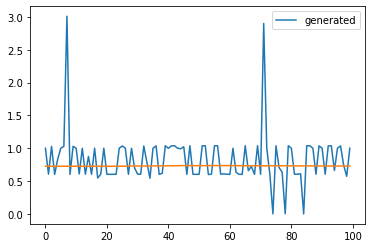

In [100]:
plt.plot(np.arange(0,len(generated_df),1),generated_df.odor,label='generated')
plt.plot(np.arange(0,len(generated_df),1),test.odor)
plt.legend()

# plt.xlim(500,1000)

In [24]:
# Prepare the prompt
prompt = f"{text_data}\nGenerate a new odor encounter with its location and wind velocity"

# Generate new data using GPT-3
response = openai.Completion.create(
    engine="text-davinci-002", 
    prompt=prompt,
    temperature=0.7,
    max_tokens=50,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
)


generated_texts = response.choices[0].text.strip()

pattern = r"Odor encounter: (.*), Location: \((.*), (.*)\), U velocity: (.*), V velocity: (.*)."
match = re.search(pattern, generated_texts)
if match:
    new_entry = {
        "odor": float(match.group(1)),
        "xsrc": float(match.group(2)),
        "ysrc": float(match.group(3)),
        "U": float(match.group(4)),
        "V": float(match.group(5)),
    }
    print(new_entry)
    generated_df = generated_df.append(new_entry, ignore_index=True)
else:
    print("Failed to parse generated text")

,odor,xsrc,ysrc,U,V
0,10.289,1.44,-0.707,1.633,2.008


### Test Text Generator

In [5]:
def generate_chat_completion(messages, model="gpt-3.5-turbo", temperature=1, max_tokens=None):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {first_cell_value}",
    }

    data = {
        "model": model,
        "messages": messages,
        "temperature": temperature,
    }

    if max_tokens is not None:
        data["max_tokens"] = max_tokens

    response = requests.post(API_ENDPOINT, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        raise Exception(f"Error {response.status_code}: {response.text}")

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Testing you'"}
]

response_text = generate_chat_completion(messages)
print(response_text)

Hello! I'm here to help you. Please feel free to ask any questions or provide any information, and I'll do my best to assist you.
